# Preface

Over the past year, I had the opportunity to work with **out-of-core** datasets (larger than available memory) in both data engineering and analysis tasks.  
This article documents my experiments with Dask as a key tool for tackling these challenges.  

## Simulate data for continuous data integration workflow
The raw data use for testing from [Synthetic credit card transaction data](https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions) with single .csv file ~2.3GB in size.  
To test simulate continuous data ingestion, use below code to split the single csv file in to multiple files split by Year. 

In [46]:
# Set data path to support Kaggle dataset
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') == 'Interactive':
    data_path = Path("/kaggle/input/credit-card-transactions")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [47]:
os.listdir(data_path)

['sd254_users.csv',
 'User0_credit_card_transactions.csv',
 'sd254_cards.csv',
 'credit_card_transactions-ibm_v2.csv']

In [41]:
pdf = pd.read_csv(data_path/"credit_card_transactions-ibm_v2.csv", dtype={'Errors?': 'object'})

In [42]:
uniq_year = pdf["Year"].unique().tolist()

In [43]:
pdf.dtypes

User                int64
Card                int64
Year                int64
Month               int64
Day                 int64
Time               object
Amount             object
Use Chip           object
Merchant Name       int64
Merchant City      object
Merchant State     object
Zip               float64
MCC                 int64
Errors?            object
Is Fraud?          object
dtype: object

In [44]:
type(uniq_year)
uniq_year.sort()
uniq_year

[1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020]

In [45]:
for y in uniq_year:
    print(y)
    yrly_ddf = pdf[pdf["Year"] == y]
    yrly_ddf.to_csv(f"/kaggle/working/yearly_data_{y}.csv", index=False)

1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


# Working with (Distributed) Cluster 

Dask distributed client have version conflicts with library `msgpack-python`  
Fix: upgrade msgpack-python == 1.0.5  
https://github.com/dask/distributed/issues/8038  

 **reference for Cluster configuration n_worker, threads_per_worker:**
- https://stackoverflow.com/questions/57760475/difference-between-dask-distributed-localcluster-with-threads-vs-processes
- https://stackoverflow.com/questions/55784232/right-way-to-set-memory-parameters-for-localcluster-in-dask

*Parameter*  

n_workers=4 : Number of workers (Dask show _processes_ ), worker memory after allocated to core service (2G) will be distribued equally among each workers if Local machine have memory 16MB, for 4 workers each have 16 - 2 = 14 / 4 ~ 3.5G per worker.
** Running dask without without cluster configuration = single worker cluster (n_worker = 1) **   

threads_per_worker= # machine cores / # worker

memory_limit=machine memory / # n_workers : possible to set beyond the machine limit. 

**reference for Cluster configuration worker memory**
- https://distributed.dask.org/en/stable/worker-memory.html#thresholds-configuration

distributed worker memory:  
- target: 0.60     # fraction of managed memory where we start spilling to disk  
- spill: 0.70      # fraction of process memory where we start spilling to disk  
- pause: 0.80      # fraction of process memory at which we pause worker threads  
- terminate: 0.95  # fraction of process memory at which we terminate the worker

**reference for Cluster shuffle method**  
https://docs.coiled.io/blog/shuffling-large-data-at-constant-memory.html  

Shuffle is the method of transferring data between worker when function `sort`, `merge`, `groupby` called.  
P2P Shuffle is the shuflling technics help reduce worker memory footprint.  

In [4]:
from dask.distributed import LocalCluster

dask.config.set({ "distributed.worker.memory.target": 0.6, 
                 "distributed.worker.memory.spill": 0.7, 
                 "distributed.worker.memory.pause": 0.8, 
                 "distributed.worker.memory.terminate": 0.95,
                 "dataframe.shuffle.method": "p2p" }) 

client = LocalCluster(n_workers=4).get_client()

In [5]:
# Print the client to see the cluster information
print(client)

<Client: 'tcp://127.0.0.1:44945' processes=4 threads=4, memory=15.02 GiB>


In [6]:
# Show the dashboard link
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.02 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44945,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.02 GiB
Comm: tcp://127.0.0.1:42513,Total threads: 1
Dashboard: http://127.0.0.1:36333/status,Memory: 3.75 GiB
Nanny: tcp://127.0.0.1:41947,


In [7]:
# Show the dashboard link
client.dashboard_link

'http://127.0.0.1:8787/status'

# Case 1) Datamart without Hive Partition

## Datamart creation
**Configuration**
- Appending each raw data in to parquet.
- Set index on column `Card` by each raw file ingested, since `Card` is non-unique then division in each raw file ingest need to turn off (`ignore_divisions=True`) for appending into .pqrquet
- The index columns is sorted by default
- Non-Hive style partition folder (no `partition_on` parameter)

In [34]:
schema = {
    "User": "int64",
    "Card": "int64",
    "Year": "int64",
    "Month": "int64",
    "Day": "int64",
    "Time": "string",
    "Amount": "string",
    "Use Chip": "string",
    "Merchant Name": "int64",
    "Merchant City": "string",
    "Merchant State": "string",
    "Zip": "float64",
    "MCC": "int64",
    "Errors?": "string",
    "Is Fraud?": "string"
}

In [36]:
yr_rng = list(range(1991, 2021))
data_combined = data_path/"credit"/"data_combined_no_hive_sort_idx_no_div.parquet"

for y in yr_rng:
    print(y)
    yrly_ddf = dd.read_csv(data_path/"credit"/f"yearly_data_{y}.csv", dtype=schema)
    yrly_ddf = yrly_ddf.set_index("Card", partition_size="100MB")
    
    if data_combined.exists():    
        yrly_ddf.to_parquet(data_combined, append=True, ignore_divisions=True)
    else:
        yrly_ddf.to_parquet(data_combined)

1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


## Query performance
Reference tips to optimized query performance  

Indexing  
- https://stackoverflow.com/questions/75915860/dask-and-best-practices-with-multiple-indices
- https://stackoverflow.com/questions/16626058/what-is-the-performance-impact-of-non-unique-indexes-in-pandas

Joining performance 
- https://stackoverflow.com/questions/71233619/why-do-i-get-always-a-memory-error-after-i-run-dask-with-big-dataframes
- https://docs.dask.org/en/latest/dataframe-joins.html#sorted-joins
- https://www.coiled.io/blog/dask-dataframe-merge-join

The duplicated index (User) force output without division metadata

In [8]:
parquet_path = data_path/"credit"/"data_combined_no_hive_sort_idx_no_div.parquet"
ddf = dd.read_parquet(parquet_path)

In [63]:
# Number of partitions = number of raw ingested files (no need to split, due to small size)
ddf.npartitions

30

In [64]:
# Unknown divisions, since the specified not to store divisions
ddf.known_divisions

False

In [65]:
# Check index type, and name 'Card'
ddf.index.head()

Index([1, 1, 1, 1, 1], dtype='int64', name='Card')

In [66]:
# The rest of data frame columns will excluding the index
ddf.columns

Index(['User', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?'],
      dtype='object')

In [70]:
%%timeit
ddf.groupby("Card")["MCC"].nunique().compute()

3.49 s ± 225 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [74]:
%%timeit
# To groupby and aggregate index column, reset_index() is needed
ddf.reset_index().groupby("User")["Card"].nunique().compute()

3.48 s ± 279 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
ddf.groupby("Year")["Zip"].sum().compute()

2.8 s ± 218 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%%timeit
ddf.query("Year == 2010")["User"].count().compute()

The slowest run took 316.90 times longer than the fastest. This could mean that an intermediate result is being cached.
7.36 s ± 6.39 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


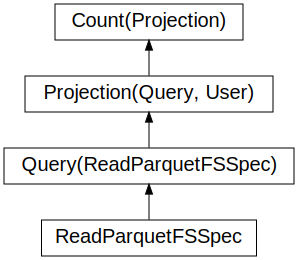

In [25]:
ddf.query("Year == 2010")["User"].count().visualize()

# Case 2) Datamart with Hive Parition
**Reference**   
- https://docs.dask.org/en/latest/dataframe-hive.html

**Configuration**
- Appending each raw data in to parquet.
- Set index on column `Card` by each raw file ingested, since `Card` is non-unique then division in each raw file ingest need to turn off (`ignore_divisions=True`) for appending into .pqrquet
- The index columns is sorted by default
- With Hive style partition folder on columns "Year" (`partition_on`="Year")

In [ ]:
schema = {
    "User": "int64",
    "Card": "int64",
    "Year": "int64",
    "Month": "int64",
    "Day": "int64",
    "Time": "string",
    "Amount": "string",
    "Use Chip": "string",
    "Merchant Name": "int64",
    "Merchant City": "string",
    "Merchant State": "string",
    "Zip": "float64",
    "MCC": "int64",
    "Errors?": "string",
    "Is Fraud?": "string"
}

In [51]:
yr_rng = list(range(1991, 2021))
data_combined = data_path/"credit"/"data_combined_with_hive_sort_idx_no_div.parquet"

for y in yr_rng:
    print(y)
    yrly_ddf = dd.read_csv(data_path/"credit"/f"yearly_data_{y}.csv", dtype=schema)
    yrly_ddf = yrly_ddf.set_index("Card", partition_size="100MB")
    
    if data_combined.exists():    
        yrly_ddf.to_parquet(data_combined, append=True, ignore_divisions=True, partition_on=["Year"])
    else:
        yrly_ddf.to_parquet(data_combined, partition_on=["Year"])

1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


## Query performance

In [10]:
parquet_path = data_path/"credit"/"data_combined_with_hive_sort_idx_no_div.parquet"
ddf2 = dd.read_parquet(parquet_path)

In [53]:
# Number of partitions = number of raw ingested files (no need to split, due to small size)
ddf2.npartitions

30

In [54]:
# Unknown divisions, since the specified not to store divisions
ddf2.known_divisions

False

In [55]:
# Check index type, and name 'Card'
ddf2.index.head()

Index([1, 1, 1, 1, 1], dtype='int64', name='Card')

In [56]:
# The rest of data frame columns will excluding the index
ddf2.columns

Index(['User', 'Month', 'Day', 'Time', 'Amount', 'Use Chip', 'Merchant Name',
       'Merchant City', 'Merchant State', 'Zip', 'MCC', 'Errors?', 'Is Fraud?',
       'Year'],
      dtype='object')

With hive partitionning, there are overhead on folder scanning

In [71]:
%%timeit
ddf2.groupby("User")["MCC"].nunique().compute()

4.45 s ± 290 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
%%timeit
ddf2.reset_index().groupby("User")["Card"].nunique().compute()

3.5 s ± 555 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
ddf2.groupby("Year")["Zip"].sum().compute()

3.2 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit
ddf2.query("Year == 2010")["User"].count().compute()

13.5 s ± 1.51 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


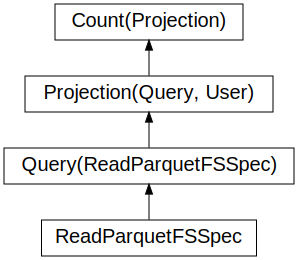

In [21]:
ddf2.query("Year == 2010")["User"].count().visualize()

To fully utilized hive partition, filtering must definded on `read_parquet` with `filter` parameter defined  
No predicate pushdown at query optimization like Spark

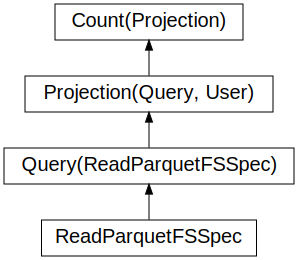

In [27]:
parquet_path = data_path/"credit"/"data_combined_with_hive_sort_idx_no_div.parquet"
year_2010 = dd.read_parquet(parquet_path, filters=[("Year", "==", 2010)])
year_2010.query("Year == 2010")["User"].count().visualize()

In [30]:
%%timeit
year_2010.query("Year == 2010")["User"].count().compute()

1.35 s ± 95.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
